<a href="https://colab.research.google.com/github/crodier1/machine_learning_deep_learning/blob/main/Sentiment_Analysis_on_Amazon_Product_Reviews_Bidirectional_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This model reads Amazon product reviews and determines if the client was either satisfied or disatisfied with the product. It uses a Bidirectiona RNN.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Bidirectional, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
!pip install opendatasets
import opendatasets as od
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
!wget -nc https://archive.ics.uci.edu/static/public/331/sentiment+labelled+sentences.zip

File ‘sentiment+labelled+sentences.zip’ already there; not retrieving.



In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20_000
EMBEDING_DIM = 100
VALIDATION_SPLIT = 0.2
EPOCHS = 35
BATCH_SIZE = 128

In [4]:
if not os.path.exists("/content/sentiment labelled sentences"):
  !unzip sentiment+labelled+sentences.zip -d /content

In [5]:
if not os.path.exists("/content/glove6b"):
  od.download("https://nlp.stanford.edu/data/glove.6B.zip")
  !unzip glove.6B.zip -d /content/glove6b

In [6]:
print('Loading word vectors...')
word2vec = {}

with open(os.path.join('/content/glove6b/glove.6B.%sd.txt' % EMBEDING_DIM)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [7]:
dataset = pd.read_csv("/content/sentiment labelled sentences/amazon_cells_labelled.txt", sep="\t", header=None)


In [8]:
dataset.columns = ["text", "label"]

In [9]:
print('loading reviews')

sentences = dataset["text"].fillna("DUMMY_VALUE").values
targets = dataset["label"].astype(float).values

loading reviews


In [10]:
print('max sequence length:', max(len(s) for s in sentences))
print('min sequence length:', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median sequence length:', s[len(s) // 2])

max sequence length: 149
min sequence length: 11
median sequence length: 48


In [11]:
tolkenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tolkenizer.fit_on_texts(sentences)
sequences = tolkenizer.texts_to_sequences(sentences)

In [12]:
word2idx = tolkenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 1878 unique tokens.


In [13]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (1000, 100)


In [14]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [15]:
embedding_layer = Embedding(
    num_words,
    EMBEDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
print('Building model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
output = Dense(1, activation='sigmoid')(x)

Building model...


In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best model
)

In [18]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [19]:
print('training model...')
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping]
)

training model...
Epoch 1/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 676ms/step - accuracy: 0.5166 - loss: 0.6948 - val_accuracy: 0.5850 - val_loss: 0.6832
Epoch 2/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.6153 - loss: 0.6627 - val_accuracy: 0.5850 - val_loss: 0.6730
Epoch 3/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.6693 - loss: 0.6430 - val_accuracy: 0.7100 - val_loss: 0.6544
Epoch 4/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.7420 - loss: 0.6146 - val_accuracy: 0.6850 - val_loss: 0.6440
Epoch 5/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.7881 - loss: 0.5766 - val_accuracy: 0.7050 - val_loss: 0.6272
Epoch 6/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.7746 - loss: 0.5558 - val_accuracy: 0.7050 - val_loss: 0.6089
Epoch 7/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7650 - loss: 0.5267 - val_accuracy: 0.7200 - val_loss: 0.5885
Epoch 8/35
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.7860 - loss: 0.4894 - val_accuracy:

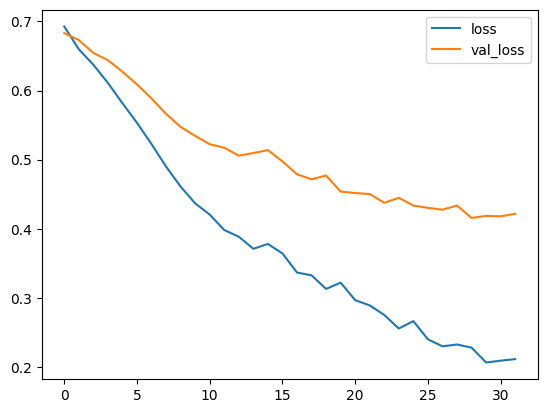

In [20]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

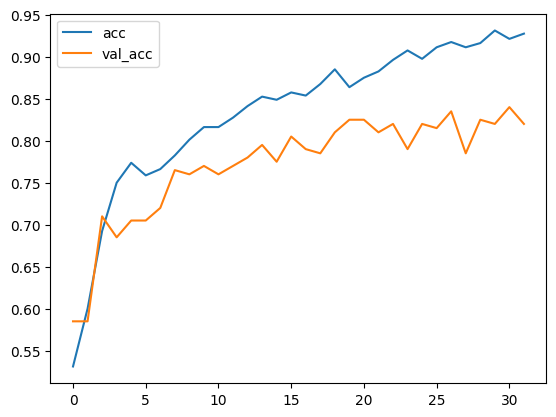

In [21]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()